In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [3]:
class FNNModel(nn.Module):
    def __init__(self):
        super(FNNModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
model = FNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
train_loss_history = []
test_loss_history = []

In [6]:
def test_iteration(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    return avg_test_loss

In [7]:
def train(model, train_loader, test_loader, optimizer, criterion):
    model.train()
    iteration = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Record the training loss for each iteration
        train_loss_history.append(loss.item())

        # Test model at each iteration and record the test loss
        avg_test_loss = test_iteration(model, test_loader, criterion)
        test_loss_history.append(avg_test_loss)

        iteration += 1
        if iteration % 200 == 0:
            print(f'Iteration {iteration}, Training Loss: {loss.item():.4f}, Test Loss: {avg_test_loss:.4f}')

In [8]:
epochs = 2
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}')
    train(model, train_loader, test_loader, optimizer, criterion)

Epoch 1
Iteration 200, Training Loss: 0.3977, Test Loss: 0.3308
Iteration 400, Training Loss: 0.2951, Test Loss: 0.2704
Iteration 600, Training Loss: 0.1852, Test Loss: 0.2169
Iteration 800, Training Loss: 0.2044, Test Loss: 0.1990
Epoch 2
Iteration 200, Training Loss: 0.1922, Test Loss: 0.1598
Iteration 400, Training Loss: 0.0782, Test Loss: 0.1581
Iteration 600, Training Loss: 0.1561, Test Loss: 0.1385
Iteration 800, Training Loss: 0.1065, Test Loss: 0.1237


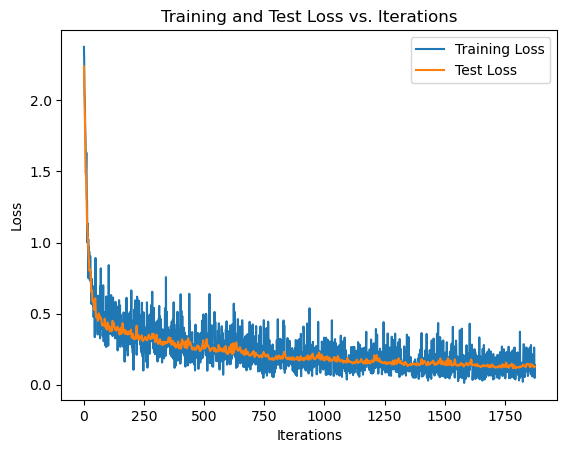

In [9]:
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.title('Training and Test Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# This code is inspired by the following reference: [MNISTOptim](https://github.com/kamileren/MNISTOptim)